In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

# Mental Health CLD Data Set 

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
#Read in data
df_mental = pd.read_csv(r'/content/drive/MyDrive/CS5010/MHCLD_reduced.csv') #dataset in CSV
xls = pd.ExcelFile(r'/content/drive/MyDrive/CS5010/CS5010Project.xlsx') #excel file with codes for df_meantal
df_states_mental = pd.read_excel(xls, 'STATEFIP State Codes') #spreadsheet page with the codes for states df_mental dataframe
df_RACE = pd.read_excel(xls, 'RACE')
df_MH1 = pd.read_excel(xls,'MH1 Primary Diagnosis')
df_age_label = pd.read_excel(xls,'AGE')

### Data Cleaning

#### Not much to clean, just missing values of the variables of interest.

In [24]:
#Adding text to key variables.  The original data is coded.
#State names
df_mental_states = df_mental.merge(df_states_mental, left_on="STATEFIP", right_on="Value") #Value and STATEFIP should be equal
df_mental_states = df_mental_states.drop(['Value'], axis=1) #remove Value column in an effort to try and keep the massive file smaller

#Diagnosis Names
df_mental_labeled = df_mental_states.merge(df_MH1, left_on="MH1", right_on="Value")
df_mental_labeled = df_mental_labeled.drop(['Value'], axis=1)

#age labels
df_mental_labeled = df_mental_labeled.merge(df_age_label, left_on="AGE", right_on="Value")
df_mental_labeled = df_mental_labeled.drop(['Value'], axis=1)
df_mental_labeled.tail()

,YEAR,AGE,RACE,MH1,STATEFIP,State,Label,Age_Range
6213786,2018,-9,-9,12,53,Washington,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213787,2018,-9,-9,12,53,Washington,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213788,2018,-9,-9,12,53,Washington,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213789,2018,-9,-9,12,99,Other Jurisdictions,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213790,2018,-9,-9,12,99,Other Jurisdictions,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid


In [73]:
#Creating a dataset that removes some of the missing values.  This are used in later analysis and analysis on the total number of cases is performed on 
#the dataframe that has not been reduced. 
#remove any unknown variables in the State column
df_states_pov = df_mental_labeled.loc[df_mental_labeled['STATEFIP'] != 99] #remove other jurisdiction from dataset to only focus on states
#df_states_pov = df_states_pov.loc[df_states_pov['STATEFIP'] != 72]
df_states_pov = df_states_pov.loc[df_states_pov['AGE'] != -9]#remove Puetro Rico from dataset to focus on states 
df_states_pov.sort_values(by=['STATEFIP'])
df_states_pov.tail() #the df is sorted by STATEFIP

,YEAR,AGE,RACE,MH1,STATEFIP,State,Label,Age_Range
6209715,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6209716,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6209717,2018,2,5,12,55,Wisconsin,Alcohol or substance use disorders,12-14
6209718,2018,2,-9,12,72,Puerto Rico,Alcohol or substance use disorders,12-14
6209719,2018,2,5,12,72,Puerto Rico,Alcohol or substance use disorders,12-14


#### Check to ensure Puerto Rico dropped as a unit test

In [72]:
def remove_puerto_rico(df):
    df = df[df['STATEFIP'] != 72]
    df = df.reset_index(drop=True)
    return df

In [75]:
remove_puerto_rico(df_states_pov)

,YEAR,AGE,RACE,MH1,STATEFIP,State,Label,Age_Range
0,2018,7,6,6,1,Alabama,Bipolar disorders,30-34
1,2018,7,5,6,1,Alabama,Bipolar disorders,30-34
2,2018,7,3,6,1,Alabama,Bipolar disorders,30-34
3,2018,7,5,6,1,Alabama,Bipolar disorders,30-34
4,2018,7,5,6,1,Alabama,Bipolar disorders,30-34
...,...,...,...,...,...,...,...,...
6206411,2018,2,3,12,54,West Virginia,Alcohol or substance use disorders,12-14
6206412,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6206413,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6206414,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14


# Exploritory Data - What are some key varaibles?

Text(0, 0.5, 'Number of Mental Health Cases')

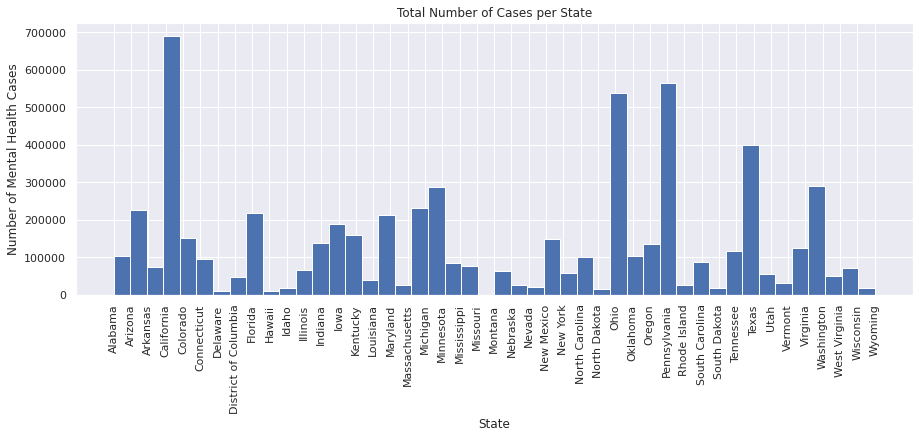

In [59]:
#Number of Cases per State
plt.rcParams["figure.figsize"] = (15,5)
plt.hist(df_states_pov['State'],bins = 46)
plt.xticks(rotation=90)
plt.title('Total Number of Cases per State')
plt.xlabel('State')
plt.ylabel('Number of Mental Health Cases')

#### States with highest totals are California, Ohio, and Pennsylvania

# Single Variable Analysis

## Age

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77230bd610>,
      dtype=object)

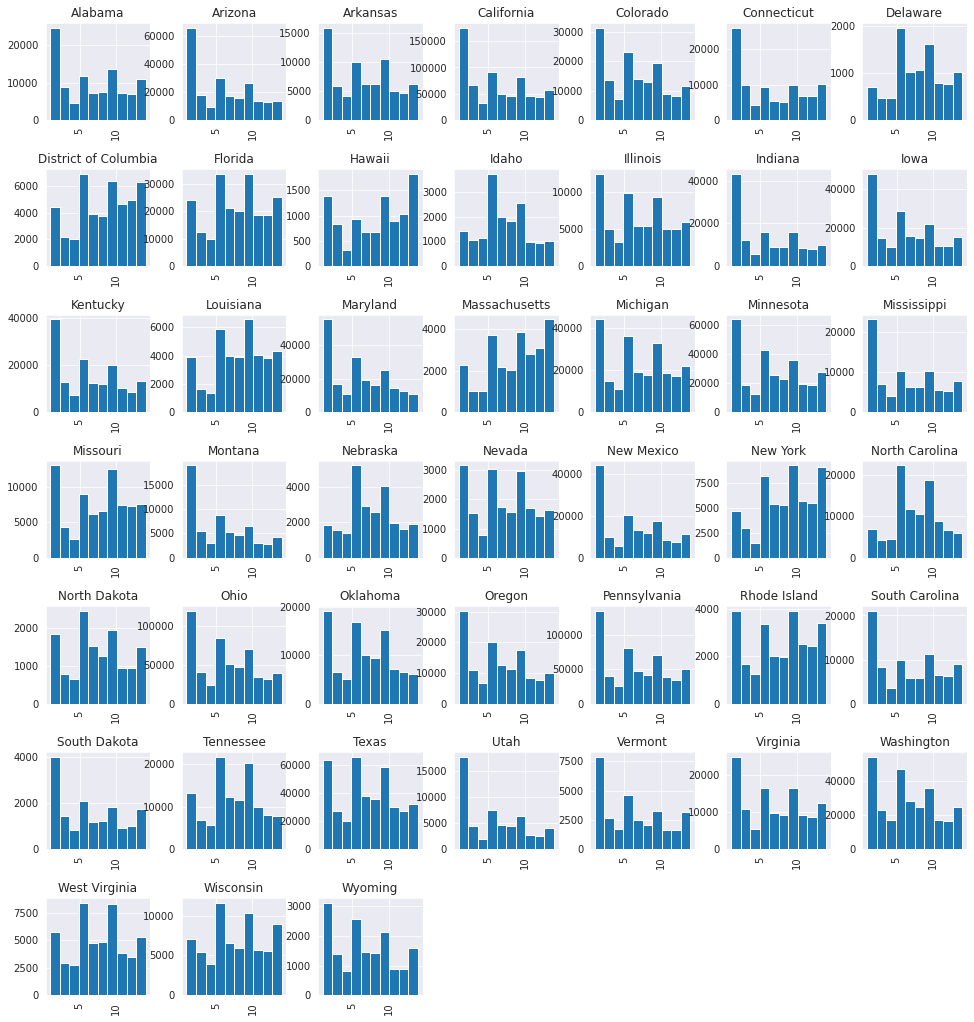

In [29]:
#using the dataset with missing age data removed. 
df_states_pov['AGE'].hist(by = df_states_pov['State'], figsize = (16,18)) # did not to the column with the labels as this is exploratory

### The age group 1 seems to have a large number of states wtih a high total, does that hold up over all?

In [30]:
age = df_states_pov.groupby('State')['Age_Range'].value_counts().to_frame() #create dataframe taht totals up teh cases by age
age = age.reset_index(0)

In [31]:
age.rename(columns={age.columns[1]: "total"}, inplace=True) #rename the column after moving to dataframe
new_age = age.reset_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

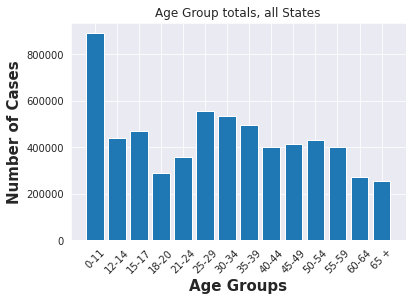

In [32]:
#totals per age group, no states
Totals_per_group = age.groupby('Age_Range')['total'].sum().to_frame().reset_index()
plt.bar(Totals_per_group['Age_Range'], Totals_per_group['total'])
plt.xlabel('Age Groups', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Cases', fontweight ='bold', fontsize = 15)
plt.title('Age Group totals, all States')
plt.xticks(rotation=45)

#### Group 1 (Ages 0-11) have the highest number of cases overall.

## Primary Mental Health Diagnosis

### What is the breakdown of mental health diagnoses per state?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7721e9b3d0>,
      dtype=object)

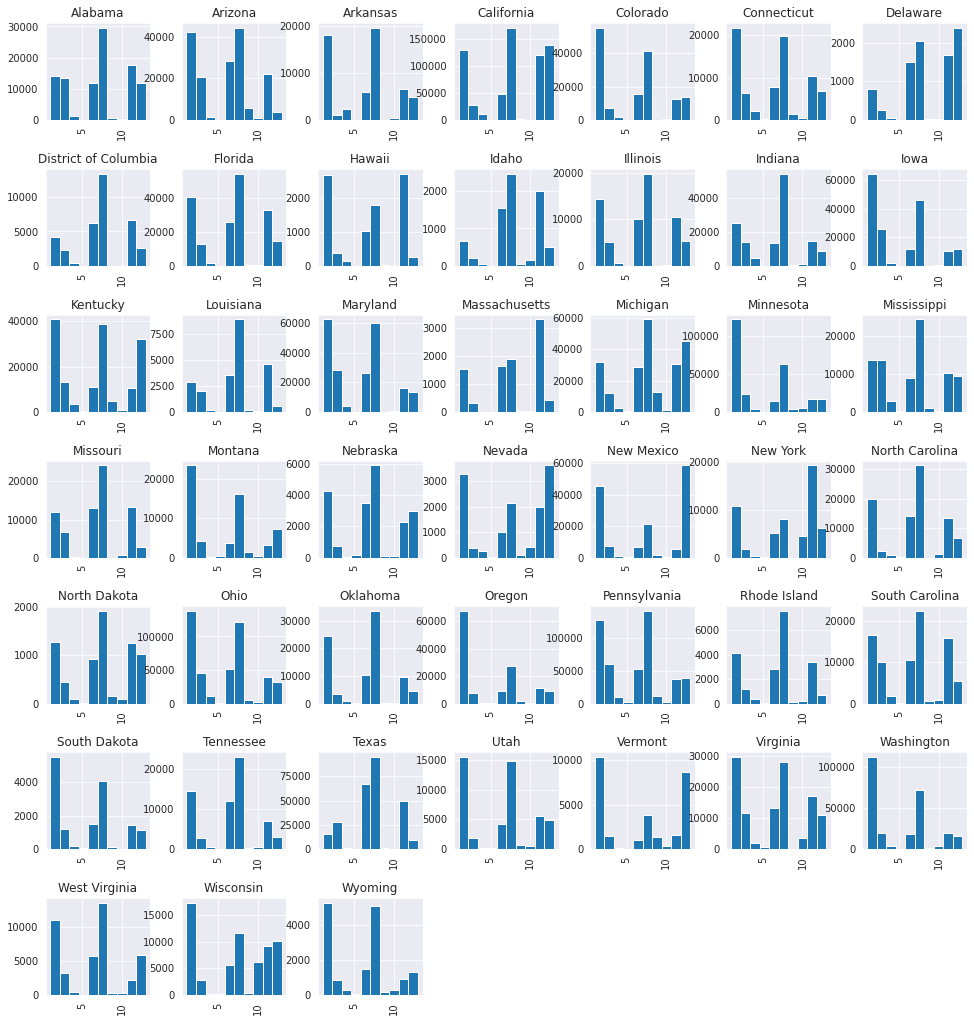

In [33]:
#using the dataset with missing MH1 data removed. 
df_states_mh1 = df_states_pov.loc[df_states_pov['MH1'] != -9]
df_states_mh1['MH1'].hist(by = df_states_mh1['State'], figsize = (16,18)) # did not to the column with the labels as this is exploratory

#### Quite a few with with low diagnosis, what are the totals over all?

In [34]:
mh1 = df_states_mh1.groupby('State')['Label'].value_counts().to_frame() #create dataframe taht totals up teh cases by age
mh1.rename(columns={mh1.columns[0]: "total"}, inplace=True)
mh1 = mh1.reset_index()
mh1.head()

,State,Label,total
0,Alabama,Depressive disorders,27590
1,Alabama,Schizophrenia or other psychotic disorders,17751
2,Alabama,Attention deficit/hyperactivity disorder (ADD/...,13668
3,Alabama,Other disorders/conditions,11864
4,Alabama,Bipolar disorders,11830


Text(0.5, 1.0, 'Mental Health Cases per Diagnosis')

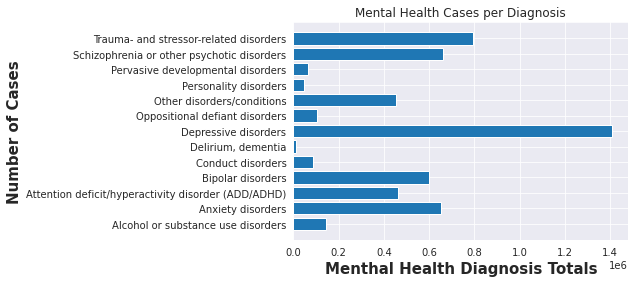

In [38]:
#totals per mh1, no states
Totals_per_mh1 = mh1.groupby('Label')['total'].sum().to_frame().reset_index()
plt.barh(Totals_per_mh1['Label'], Totals_per_mh1['total'])
plt.xlabel('Menthal Health Diagnosis Totals', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Cases', fontweight ='bold', fontsize = 15)
plt.title('Mental Health Cases per Diagnosis')

#### Over all, it seems that depressive disorders are the main diagnosis, How does that apply on a state by state basis?

# Multivariable Analysis

## How do mental health diagnosis vary by Age Group?

In [39]:
#Dataset with missing data of the primary health diagnosis removed and arranged for graphing
df_mental_labeled1 = df_mental_labeled.loc[df_mental_labeled['AGE'] != -9] 
age_mh1 = df_mental_labeled1.groupby('Age_Range')['Label'].value_counts().to_frame()
age_mh1.rename(columns={age_mh1.columns[0]: 'Total_Cases' }, inplace = True)
age_mh1 = age_mh1.reset_index()

In [40]:
#create a dataframe with both age and Mh1 along with their totals, and change the label to diagnosis
age_mh1 = age_mh1.rename(columns={"Label" : "Diagnosis"})
age_mh1.head()

,Age_Range,Diagnosis,Total_Cases
0,0-11,Attention deficit/hyperactivity disorder (ADD/...,232353
1,0-11,Trauma- and stressor-related disorders,227728
2,0-11,Other disorders/conditions,91534
3,0-11,Missing/Unknown,88932
4,0-11,Anxiety disorders,84127


[Text(0, 0.5, 'Age Range'), Text(0.5, 0, 'Number of Cases')]

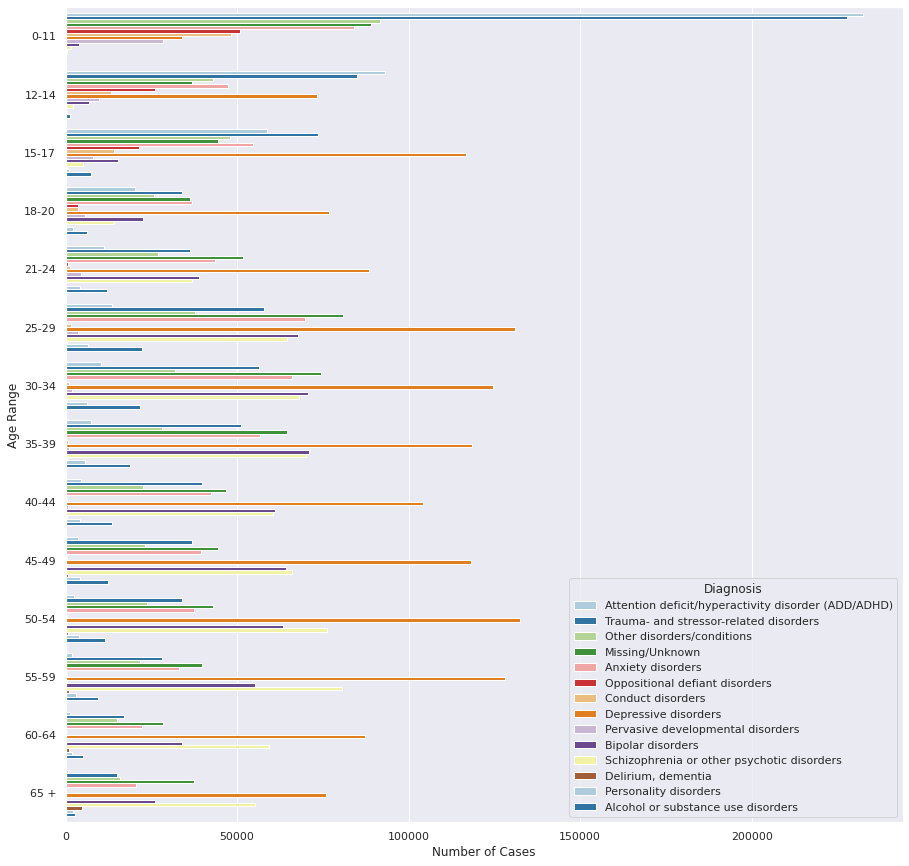

In [61]:
sns.set(rc={'figure.figsize':(15,15)})
sns.color_palette("vlag", as_cmap=True)
ax = sns.barplot(y="Age_Range", x="Total_Cases", hue="Diagnosis", data=age_mh1, palette = 'Paired')
ax.set(xlabel='Number of Cases', ylabel='Age Range')

# Unit Test

In [78]:
#Test to see if puerto rico was removed

import unittest
from pandas._testing import assert_frame_equal

class PuertoRicoTestCase(unittest.TestCase): # inherit from unittest.TestCase
    
    def test_can_remove_puerto_rico(self):
        data_removed = [['Kansas', 54], ['Utah', 14]]
        correct_df = pd.DataFrame(data_removed, columns = ['State', 'STATEFIP'])
        
        data = [['Puerto Rico', 72], ['Kansas', 54], ['Utah', 14]]
        test_df = pd.DataFrame(data, columns = ['State', 'STATEFIP'])
        test_df.reset_index()
        
        new_df = remove_puerto_rico(test_df)
        
        assert_frame_equal(correct_df, new_df) 
                
            
unittest.main(argv=[''],exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.011s

OK
